# Different Terrain Types Classification

https://www.kaggle.com/datasets/durgeshrao9993/different-terrain-types-classification

In [19]:
from glob import glob

labels = []
image_paths = []


for g in glob('./data/SIH_NN/*'):
    print('----', g)
    for m in glob(g + '/*'):
        labels.append(g.split('/')[-1])
        image_paths.append(m)
        
print(len(labels), len(image_paths))
        
        

---- ./data/SIH_NN/Forest
---- ./data/SIH_NN/Plains
---- ./data/SIH_NN/Mountain
---- ./data/SIH_NN/Desert
3196 3196


In [20]:
# labels를 숫자로 바꾸기

import numpy as np

label_to_index = {}
index_to_label = {}

for i, label in enumerate(set(labels)):
    label_to_index[label] = i
    index_to_label[i] = label
    
print(label_to_index)

labels = [label_to_index[label] for label in labels]


print(labels[:10], type(labels))

labels = np.array(labels)

print(labels[:10], type(labels))

{'Desert': 0, 'Forest': 1, 'Mountain': 2, 'Plains': 3}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] <class 'list'>
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'>


In [21]:
# 각 라벨별로 이미지가 몇개씩 있는지 확인

from collections import Counter

Counter(labels)

Counter({1: 799, 3: 799, 2: 799, 0: 799})

In [22]:
# 이미지 크기가 모두 같은지 확인
# 비율이 같은지 확인

from PIL import Image

sizes = []
for i in image_paths:
    img = Image.open(i)
    sizes.append(img.size)
    
print(Counter(sizes))

Counter({(256, 256): 2026, (600, 600): 1170})


이미지 크기가 256*256 혹은 600 * 600 으로 두가지가 있음

256 * 256 으로 모두 변환하여 처리 하는게 낫겠음

In [23]:
from tqdm import tqdm


# 이미지 파일을 읽어서 numpy array로 변환
images = []


for i in tqdm(image_paths):
    img = Image.open(i)
    
    # # 만약 이미지가 256x256이 아니라면 resize
    # if img.size != (256, 256):
        # img = img.resize((256, 256))
    img = img.resize((128, 128))
    img = np.array(img)
    
    images.append(img)
    
images = np.array(images)
    
print(images.shape)
    

100%|██████████| 3196/3196 [00:06<00:00, 464.01it/s]

(3196, 128, 128, 3)


RGB 이기 때문에 3

사막과 풀이 있는 지역을 구분하려면 RGB값을 쓰는게 낫겠다. 물론 사실 평균 때려서 초록색 있는지만 봐도 되겠지만.

In [24]:
# 256, 256, 3인 것에서 최대 최소 값을 구하자. 
print(images.min(), images.max())


0 255


In [25]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

train_x, rest_x, train_y, rest_y = train_test_split(images, labels, test_size=0.4, stratify=labels)
val_x, test_x, val_y, test_y = train_test_split(rest_x, rest_y, test_size=0.5, stratify=rest_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(len(train_y), len(val_y), len(test_y))

(1917, 128, 128, 3) (639, 128, 128, 3) (640, 128, 128, 3)
1917 639 640


In [26]:
def model_fn_for_image(a_layer=None):
    model = keras.Sequential()
    model.add(keras.Input(shape=(128, 128, 3))) 
    model.add(keras.layers.Conv2D(8, 3, activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(16, 3, activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Flatten())
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(4, activation='softmax', name='output'))
    
    return model
    

In [27]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.Input(shape=(128, 128, 3)))
    model.add(keras.layers.Flatten())
    if a_layer:
        model.add(a_layer)
    
    # model.add(keras.layers.Dense(512, activation='relu'))
    # model.add(keras.layers.Dense(256, activation='relu'))
    # model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    if a_layer:
        model.add(a_layer)
        
    model.add(keras.layers.Dense(4, activation='softmax', name='output'))
    
    return model

In [28]:
model = model_fn_for_image(keras.layers.Dropout(0.3)) # 30%의 노드를 끈다.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,564 (642.83 KB)

 Trainable params: 164,564 (642.83 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
print(train_x.shape, type(train_x), train_y[:10], type(train_y))

(1917, 128, 128, 3) <class 'numpy.ndarray'> [1 2 0 2 3 0 2 1 2 3] <class 'numpy.ndarray'>


Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5126 - loss: 1.3433 - val_accuracy: 0.7152 - val_loss: 0.7529
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7255 - loss: 0.7292 - val_accuracy: 0.7621 - val_loss: 0.5695
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7616 - loss: 0.5647 - val_accuracy: 0.7903 - val_loss: 0.5156
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7983 - loss: 0.5049 - val_accuracy: 0.8498 - val_loss: 0.4224
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8404 - loss: 0.4075 - val_accuracy: 0.8513 - val_loss: 0.3863
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8337 - loss: 0.4588 - val_accuracy: 0.8576 - val_loss: 0.3796
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8611 - loss: 0.3885 - val_accuracy: 0.8341 - val_loss: 0.4285
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8564 - loss: 0.3915 - val_accuracy: 0.9045 - v

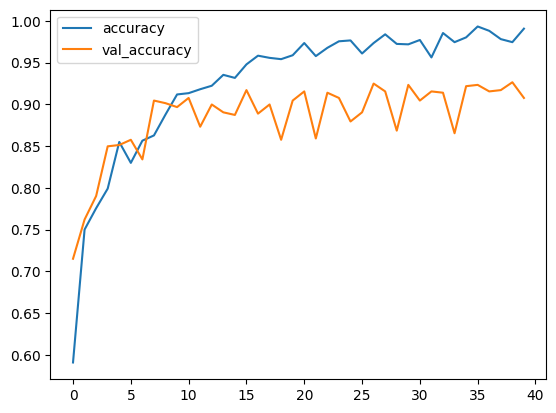

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-terrain-classification.model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=40, callbacks=[checkpoint_cb, early_stopping_cb])

from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.legend()
plt.show()

In [31]:
model.evaluate(test_x, test_y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9221 - loss: 0.2575


[0.2809140980243683, 0.9234374761581421]

In [32]:
model.evaluate(val_x, val_y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9292 - loss: 0.2472


[0.278160959482193, 0.9233176708221436]

In [33]:
model.evaluate(test_x, test_y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9221 - loss: 0.2575


[0.2809140980243683, 0.9234374761581421]